# Density Based Clustering (DBSCAN)

### Data Mining Project 2024/25

Authors: Nicola Emmolo, Simone Marzeddu, Jacopo Raffi

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
from scipy.spatial.distance import pdist
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler, MinMaxScaler

import seaborn as sns
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
from scipy.cluster.hierarchy import fcluster

In [3]:
dataset = pd.read_csv('../data/complete_dataset_fe.csv', dtype={'cyclist_team': str})
dataset['date'] = pd.to_datetime(dataset['date'], format='%Y-%m-%d')
dataset = dataset[['length','race_prestige', 'race_physical_effort']].drop_duplicates()

In [4]:
'''
Clustering Features Races:
- race_prestige (ignore: points, uci_points, startlist_quality)
- race_physical_effort (ignore: climb_total, profile, climb_percentage)
- lenght

Additionally, ignore race_year (not informative for clustering in our opinion)
'''


'''
Clustering Features Cyclists:
- cyclist_bmi (ignore: weight)
- height
- mean_delta
- cyclist_climb_power
'''

'\nClustering Features Cyclists:\n- cyclist_bmi (ignore: weight)\n- height\n- mean_delta\n- cyclist_climb_power\n'

### Races Clustering

In [5]:
# Select relevant columns for clustering
columns_to_use = ['length','race_prestige', 'race_physical_effort']

data_for_clustering = dataset.dropna() #TODO: remove when we have imputed the missing values

# Standardize the data
scaler = StandardScaler()
data_scaled = scaler.fit_transform(data_for_clustering)

In [6]:
# Apply DBSCAN
dbscan = DBSCAN(eps=0.5, min_samples=10)
clusters = dbscan.fit_predict(data_scaled)

# Add cluster labels to the data
data_for_clustering['cluster'] = clusters

# Display cluster distribution
print(data_for_clustering['cluster'].value_counts())
print(data_for_clustering.head())

cluster
 0    2526
-1      53
 1      32
Name: count, dtype: int64
   length  race_prestige  race_physical_effort  cluster
4     5.2       0.193636              0.000024        0
5   135.0       0.193636              0.011103        0
6   100.0       0.193636              0.007473        0
7   199.0       0.193636              0.069027        0
8   244.0       0.193636              0.156260        0


/tmp/ipykernel_6703/4242254131.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_for_clustering['cluster'] = clusters


In [7]:
# Analyze the mean and standard deviation of numerical features for each cluster
cluster_stats = data_for_clustering.groupby('cluster').agg(['mean', 'std'])
print("Cluster Statistics:\n", cluster_stats)

Cluster Statistics:
              length            race_prestige           race_physical_effort  \
               mean        std          mean       std                 mean   
cluster                                                                       
-1       257.656604  46.821229      0.416684  0.199626             0.388330   
 0       163.617918  59.502316      0.159677  0.086875             0.169377   
 1       252.909375   7.347212      0.461054  0.051578             0.312804   

                   
              std  
cluster            
-1       0.287027  
 0       0.155709  
 1       0.053361  


In [8]:
# Identify outliers (cluster label -1)
outliers = data_for_clustering[data_for_clustering['cluster'] == -1]
print("\nNumber of outliers:", len(outliers))


Number of outliers: 53


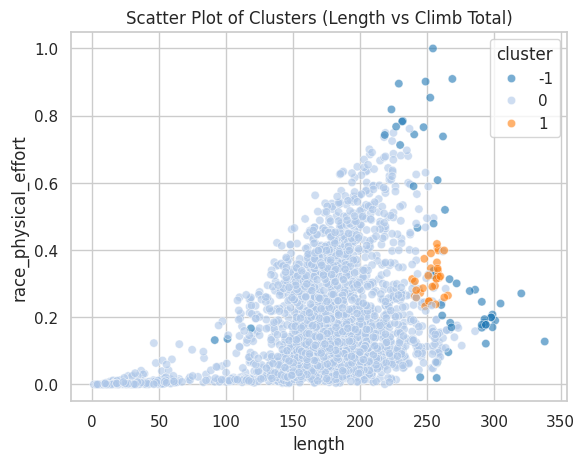

In [9]:
# Scatter plot of a few features to visualize clusters
sns.set(style="whitegrid")
sns.scatterplot(
    x='length', y='race_physical_effort', hue='cluster', palette='tab20',
    data=data_for_clustering, legend='full', alpha=0.6
)
plt.title("Scatter Plot of Clusters (Length vs Climb Total)")
plt.show()

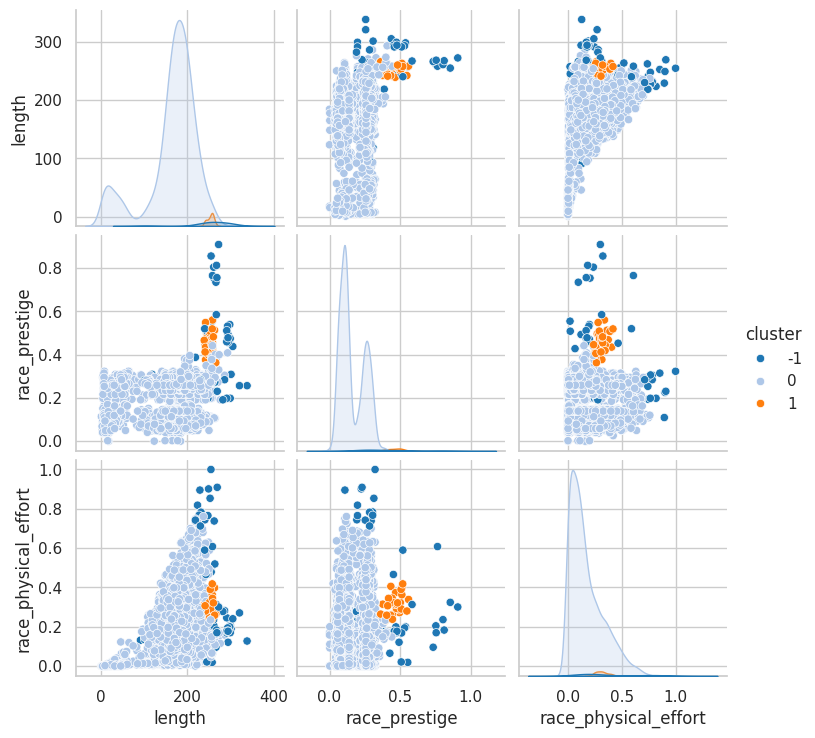

In [10]:
# Pair plot for a subset of columns
data_subset = data_for_clustering[['length','race_prestige', 'race_physical_effort', 'cluster']]
sns.pairplot(data_subset, hue='cluster', palette='tab20')
plt.show()

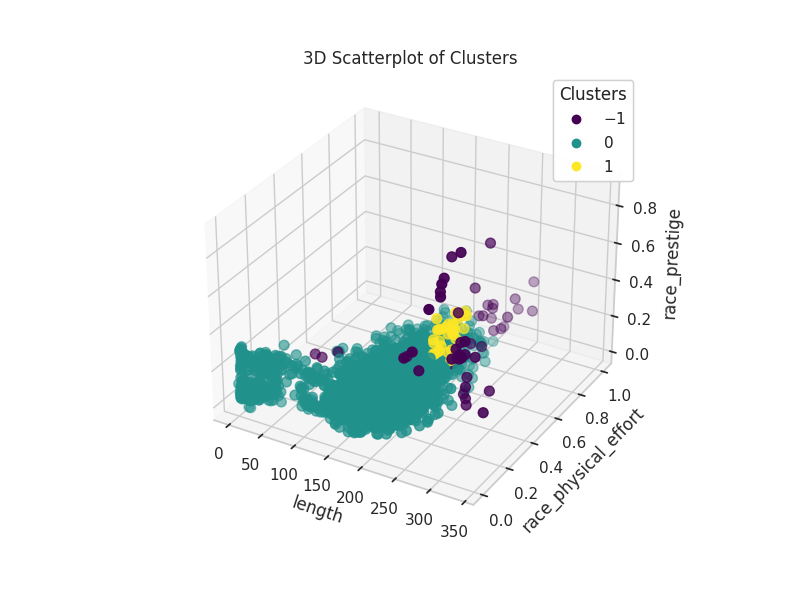

In [11]:

%matplotlib widget

x = data_for_clustering['length']  # Prima feature
y = data_for_clustering['race_physical_effort']  # Seconda feature
z = data_for_clustering['race_prestige']  # Terza feature

# Crea il grafico 3D
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')

# Scatterplot
scatter = ax.scatter(x, y, z, c=data_for_clustering['cluster'], cmap='viridis', s=50)
ax.set_xlabel('length')
ax.set_ylabel('race_physical_effort')
ax.set_zlabel('race_prestige')

# Aggiungi una legenda (opzionale)
legend1 = ax.legend(*scatter.legend_elements(), title="Clusters")
ax.add_artist(legend1)

plt.title('3D Scatterplot of Clusters')

# Abilita la modalità interattiva
plt.ion()
plt.show()